<a href="https://colab.research.google.com/github/GodingWal/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [2]:
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  p_non_user = 1-prob_drunk_prior
  numerator = (p_non_user*prob_drunk_prior)
  denominator = (p_non_user*prob_drunk_prior) + (false_positive_rate*p_non_user)
  posterior_probability = numerator / denominator
  return posterior_probability

posterior = prob_drunk_given_positive(1/200, 8/100, 1) 
posterior

0.0588235294117647

In [3]:
post = prob_drunk_given_positive(posterior, 1/100, 1)
post

0.8547008547008548

How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

3

In [0]:
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import sem, t 
from scipy import stats
import matplotlib.pyplot as plt

In [0]:
vote = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])

vote = vote.replace({'y': 1, 'n':0, '?':np.NaN})
republican = vote[vote['party']=='republican']
democrat = vote[vote['party']=='democrat']

In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.nanmean(data)
  n = len(data)
  s = data.std(ddof=1)
  stderr = stats.sem(data, nan_policy='omit')
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*stderr
  return (mean, mean - margin_of_error, mean + margin_of_error)

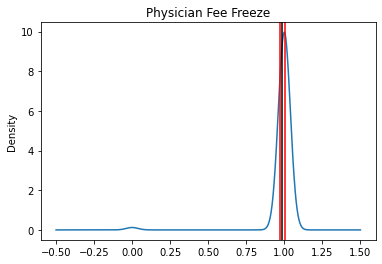

In [8]:
CI = confidence_interval(republican['physician-fee-freeze'])
republican['physician-fee-freeze'].plot.density()
plt.title("Physician Fee Freeze")
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[0], color='black')
plt.axvline(x=CI[2], color='red')

plt.show()

In [0]:
df = stats.bayes_mvs(republican['physician-fee-freeze'], alpha=0.9)

In [0]:
df

(Mean(statistic=nan, minmax=(nan, nan)),
 Variance(statistic=nan, minmax=(nan, nan)),
 Std_dev(statistic=nan, minmax=(nan, nan)))

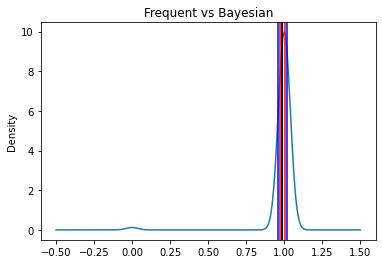

In [0]:
CI = confidence_interval(republican['physician-fee-freeze'])
republican['physician-fee-freeze'].plot.density()
plt.title("Frequent vs Bayesian")
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[0], color='black')
plt.axvline(x=CI[2], color='red')

df_array = (0.9878787878787879,0.959438776356656, 1.0163187994009197 )
plt.axvline(x=df_array[1], color='blue')
plt.axvline(x=df_array[0], color='black')
plt.axvline(x=df_array[2], color='blue')



plt.show()

In your own words, summarize the difference between Bayesian and Frequentist statistics.

Bayesian updates probability with new information as Frequentist uses information receieved at first.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!